# PDE-FIND for the Kuramoto Sivashinsky Equation

This notebook demonstrates PDE-FIND on the Kuramoto Sivashinsky equation.
$$
u_t + u_{xxxx} + uu_x + u_{xx} = 0
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter, wiener
from scipy import integrate
from scipy.integrate import trapz
from scipy.integrate import simpson as simp
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise
from functools import partial
from findiff import FinDiff

from tqdm import trange
import heapq

def percent_coeff(pred, ground=np.array([-1., -1., -1.])): 
    return 100*np.abs(pred.flatten()-ground)/np.abs(ground)

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat('../Datasets/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

assert np.max(x)/32 == np.pi

In [3]:
np.random.seed(0)
noise_lv = 30
un = u + 0.01*noise_lv*u.std()*np.random.randn(u.shape[0], u.shape[1])

In [4]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = -0.994 x0_11 + -0.996 x0_1111 + -0.992 x0x0_1


In [5]:
print('MIOSR model: ')
optimizer = ps.MIOSR(target_sparsity=3, normalize_columns=False, alpha=1e-1, regression_timeout=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

MIOSR model: 
Set parameter Username


2023-06-05 15:55:36,367 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2023-06-05 15:55:36,370 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


(x0)' = -0.994 x0_11 + -0.996 x0_1111 + -0.992 x0x0_1


In [6]:
class Differentiator(ps.BaseDifferentiation):
    def __init__(self, diff_name, diff_func_kwargs, 
                 d=1, axis=1, 
                 is_uniform=True, periodic=False):
        super(Differentiator, self).__init__()
        self.diff_name = diff_name
        self.diff_func_kwargs = diff_func_kwargs
        self.diff_func = getattr(derivative, self.diff_name)(**diff_func_kwargs)
        
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        self.transform = np.vectorize(composite_function(self.diff, lambda _: _, left2right=True), signature="(m),(m)->(m)")

    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                diff = self.transform(x[:,:,i].T, t).T
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                diff = self.transform(x[:,:,i], t)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)

class FiniteDifferentiator(ps.BaseDifferentiation):
    def __init__(self, acc=2, d=1, axis=1, is_uniform=True, periodic=False):
        super(FiniteDifferentiator, self).__init__()        
        self.acc = 2*(acc//2)
        self.d = d
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
    def _differentiate(self, x, t):
        if self.is_uniform:
            if isinstance(t, float): 
                dt = t
            else: 
                dt = t[1]-t[0]
            self.diff = FinDiff(self.axis, dt, self.d, acc=self.acc)
        else:
            raise NotImplementedError("is_uniform=False")
            self.diff = FinDiff(self.axis, self.d, acc=self.acc)
        return self.diff(x)

In [7]:
### originally from derivative ###
## slow ##
# diff_name, diff_func_kwargs = "Kalman", {'alpha':kalpha}
## fast ##
# diff_name, diff_func_kwargs = "FiniteDifference", {'k':1}
# differentiation_method = Differentiator
# differentiation_kwargs = {"diff_name": diff_name, "diff_func_kwargs": diff_func_kwargs}

# originally from pysindy
# differentiation_method, differentiation_kwargs = ps.SmoothedFiniteDifference, {}

# originally from findiff (accurate and fast)
differentiation_method, differentiation_kwargs = FiniteDifferentiator, {'acc':2}

In [8]:
diff_order = 4; spatial_weights_p = 4
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=spatial_weights_p, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}

In [9]:
# # optimizer = ps.MIOSR(target_sparsity=3, normalize_columns=False, alpha=1e-1, regression_timeout=100)
# optimizer = L0BNB(max_nonzeros=3, lam=5e-2, is_normal=True, normalize_columns=False, threshold=1e-4) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
# # optimizer = BruteForceRegressor(3)

# # if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
# n_ensemble_models = 50
# model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
#                  differentiation_method=differentiation_method(**differentiation_kwargs), 
#                  cache=True,
#                  feature_names=['u'])

# model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
# print(model.get_feature_names())
# print(model.print())

# X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot
# print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

In [10]:
optimizer = ps.MIOSR(target_sparsity=3, normalize_columns=False, alpha=5e-2, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method(**differentiation_kwargs), 
                 cache=True,
                 feature_names=['u'])

model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
print(model.get_feature_names())
print(model.print())

X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

['u', 'uu', 'u_1', 'u_11', 'u_111', 'u_1111', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11', 'uu_111', 'uuu_111', 'uu_1111', 'uuu_1111']
(u)' = -0.993 u_11 + -0.995 u_1111 + -0.998 uu_1
None
u_t = (-0.990625 +0.000000i)u_11
    + (-0.993308 +0.000000i)u_1111
    + (-0.995604 +0.000000i)uu_1
   


In [11]:
model_results = {}
for effective_indices in set([tuple(np.nonzero(model.get_coef_list()[i][0])[0]) 
                              for i in range(len(model.get_coef_list()))]):
    coeff = np.linalg.lstsq(X_pre[:, effective_indices], y_pre, rcond=None)[0]
    mse = ((y_pre-X_pre[:, effective_indices]@coeff)**2).mean()
    n_terms = len(effective_indices)
    if (n_terms > 0) and (n_terms not in model_results or mse < model_results[n_terms][1]):
        model_results[n_terms] = effective_indices, mse, coeff
        
for com in model_results:
    effective_indices, _, coeff = model_results[com]
    print_pde(coeff, np.array(model.get_feature_names())[list(effective_indices)])
    
print(percent_coeff(model_results[3][-1]).mean())
model_results

u_t = (-0.992887 +0.000000i)u_11
    + (-0.994861 +0.000000i)u_1111
    + (-0.998153 +0.000000i)uu_1
   
0.46999004572032915


{3: ((3, 5, 6),
  0.01617495345907047,
  array([[-0.99288685],
         [-0.9948606 ],
         [-0.99815284]]))}

In [12]:
# optimizer = L0BNB(max_nonzeros=5, lam=1e-1, is_normal=False, normalize_columns=False, threshold=1e-4)
# optimizer.fit(X_pre, y_pre).coef_

# mses = []
# all_possible_models = list(itertools.combinations(range(14), 3))
# for effective_indices in all_possible_models:
#     coeff = np.linalg.lstsq(X_pre[:, effective_indices], y_pre, rcond=None)[0]
#     mses.append(((y_pre-X_pre[:, effective_indices]@coeff)**2).mean())
# all_possible_models[np.argmin(mses)], np.min(mses)

#### Evidence

In [13]:
all_ols_models = []
all_eff_rhs = []
n_ensemble_models = 50; miosr_alpha = 5e-2
for mnz in range(1, 9):
    optimizer = ps.MIOSR(target_sparsity=mnz, normalize_columns=False, alpha=miosr_alpha, regression_timeout=100)    
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=differentiation_method(**differentiation_kwargs), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    all_ols_models.append(ols_model)
    all_eff_rhs.append(eff_rhs_indices)

u_t = (-0.333791 +0.000000i)uu_1
   
u_t = (-0.223216 +0.000000i)u_11
    + (-0.574863 +0.000000i)uu_1
   
u_t = (-0.992887 +0.000000i)u_11
    + (-0.994861 +0.000000i)u_1111
    + (-0.998153 +0.000000i)uu_1
   
u_t = (-0.993005 +0.000000i)u_11
    + (0.001229 +0.000000i)u_111
    + (-0.994965 +0.000000i)u_1111
    + (-0.998308 +0.000000i)uu_1
   
u_t = (0.003505 +0.000000i)u
    + (-0.993824 +0.000000i)u_11
    + (-0.995146 +0.000000i)u_1111
    + (-0.998524 +0.000000i)uu_1
    + (0.000302 +0.000000i)uuu_11
   
u_t = (0.010872 +0.000000i)u_1
    + (-0.993135 +0.000000i)u_11
    + (-0.994363 +0.000000i)u_1111
    + (-0.998453 +0.000000i)uu_1
    + (0.000462 +0.000000i)uuu_11
    + (0.000465 +0.000000i)uuu_1111
   
u_t = (0.013149 +0.000000i)u_1
    + (-0.993254 +0.000000i)u_11
    + (-0.994077 +0.000000i)u_1111
    + (-0.998535 +0.000000i)uu_1
    + (0.003518 +0.000000i)uuu_1
    + (0.000717 +0.000000i)uuu_11
    + (0.000720 +0.000000i)uuu_1111
   
u_t = (0.002925 +0.000000i)u
    + (0

In [14]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))

In [15]:
st = backward_refinement(all_eff_rhs, (X_pre, y_pre), mode='rfe', verbose=True)
st += backward_refinement(all_eff_rhs, (normalize(X_pre, axis=0), y_pre), mode='rfe', verbose=True)

RFE_PLinearRegression
(3, 6)
(6,)
--------------------------------------------------
(3, 5, 6)
(3, 6)
--------------------------------------------------
(3, 4, 5, 6)
(3, 5, 6)
--------------------------------------------------
(0, 3, 5, 6, 9)
(0, 3, 5, 6)
(3, 5, 6)
--------------------------------------------------
(2, 3, 5, 6, 9, 13)
(3, 5, 6, 9, 13)
(3, 5, 6, 13)
(3, 5, 6)
--------------------------------------------------
(2, 3, 5, 6, 7, 9, 13)
(2, 3, 5, 6, 9, 13)
--------------------------------------------------
(0, 2, 3, 5, 6, 7, 9, 13)
(2, 3, 5, 6, 7, 9, 13)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)
(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13)
(0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13)
(0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13)
(0, 2, 3, 5, 6, 7, 10, 11, 12, 13)
(0, 2, 3, 5, 6, 7, 11, 12, 13)
(0, 2, 3, 5, 6, 7, 11, 13)
(2, 3, 5, 6, 7, 11, 13)
(2, 3, 5, 6, 11, 13)
(3, 5, 6, 11, 13)
(3, 5, 6, 13)
-------------------------------------

In [16]:
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(6,)
(3, 6)
(3, 5, 6)
(3, 4, 5, 6)
(0, 3, 5, 6, 9)
(2, 3, 5, 6, 9, 13)
(2, 3, 5, 6, 7, 9, 13)
(0, 2, 3, 5, 6, 7, 9, 13)
(0, 2, 3, 5, 6, 7, 11, 12, 13)
(0, 2, 3, 5, 6, 7, 10, 11, 12, 13)
(0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13)
(0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13)
(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13)
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)


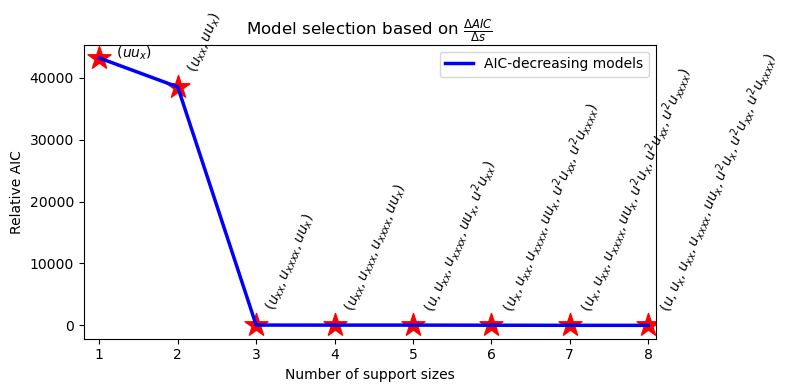

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="AIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta AIC}{\Delta s}$")
plt.ylabel("Relative AIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
print(decreasing_aics)
for c in complexities: print(c, eff_feature_names[c-1])
find_transition_V5(decreasing_aics, complexities, percent_ok=0.09)

[ 30275.8339728   25599.5127601  -12858.14249527 -12864.25869979
 -12865.05464797 -12880.66375586 -12898.78130837 -12904.31448525]
1 ['uu_{x}']
2 ['u_{xx}', 'uu_{x}']
3 ['u_{xx}', 'u_{xxxx}', 'uu_{x}']
4 ['u_{xx}', 'u_{xxx}', 'u_{xxxx}', 'uu_{x}']
5 ['u', 'u_{xx}', 'u_{xxxx}', 'uu_{x}', 'u^2u_{xx}']
6 ['u_{x}', 'u_{xx}', 'u_{xxxx}', 'uu_{x}', 'u^2u_{xx}', 'u^2u_{xxxx}']
7 ['u_{x}', 'u_{xx}', 'u_{xxxx}', 'uu_{x}', 'u^2u_{x}', 'u^2u_{xx}', 'u^2u_{xxxx}']
8 ['u', 'u_{x}', 'u_{xx}', 'u_{xxxx}', 'uu_{x}', 'u^2u_{x}', 'u^2u_{xx}', 'u^2u_{xxxx}']
3 improves 2
Percent improve: 1.502280751035022
7 does not improve 3
Percent improve: 0.0007901377107136002


3

In [19]:
errs = percent_coeff(model_results[3][-1])
errs.mean(), errs.std()

(0.46999004572032915, 0.21721774824355908)

## Calculate a weak form of each canidate

In [20]:
acc=4
# Define the derivative:
d_dx = FinDiff(0, dx, 1, acc=acc)
d_dxx = FinDiff(0, dx, 2, acc=acc)
d_dxxxx = FinDiff(0, dx, 4, acc=acc)
d_dt = FinDiff(1, dt, 1, acc=acc)

coeff = np.linalg.lstsq(np.stack([u*d_dx(u), d_dxx(u), d_dxxxx(u)]).reshape(3, -1).T, 
                        d_dt(u).reshape(-1,1), rcond=None)[0]
print((100*np.abs(coeff+1)).mean())
coeff

0.01072770358302814


array([[-0.99983724],
       [-0.99991587],
       [-0.99992506]])

In [21]:
Xf = np.stack([integrate.trapz(d_dxx(u), t, dt, axis=1), 
               integrate.trapz(d_dxxxx(u), t, dt, axis=1), 
               integrate.trapz(u*d_dx(u), t, dt, axis=1)]).T
yf = integrate.trapz(d_dt(u), t, dt, axis=1).reshape(-1,1)
coeff = np.linalg.lstsq(Xf, yf, rcond=None)[0]
print((100*np.abs(coeff+1)).mean()) # 0.00867587799540844
coeff

0.008675862373541676


array([[-1.00009514],
       [-1.00010748],
       [-1.00005765]])

In [22]:
# sio.savemat("../../PDE_Discovery_Weak_Formulation/Datasets/KS_data_tmp.mat", 
#             {'uu': un, 'xx':x, 'tt':t, 'dx':dx, 'dt': dt})

In [23]:
def weight_poly(x, m, k):
    """
    Polynomial piece of weighting function used to satisfy BC A = d^k/dx^k[(x^2 - 1)^m]
    x: independent variable
    m: power of base function
    k: order of derivative
    """
    a = np.zeros((2*m+1, 1)) # initial coefficient vector
    for l in range(m+1):
        a[2*l] = ((-1)**(m-l))*np.math.comb(m, l) # set polynomial coefficients
    
    c = np.zeros((2*m+1, 1)) # final coefficient vector
    for n in range(2*m-k+1):
        c[n] = a[n+k]*np.math.factorial(n+k)/np.math.factorial(n)
    
    p = 0
    for n in range(2*m-k+1):
        p += c[n]*(x**n) # final windowing function

    return p

def weight_full(k, p, x, t):
    """
    Assemble the 1D weight functions into the full weight
    k = [kx,ky,kt]: order of derivative(s)
    p = [px,py,pt]: exponents of weight polynomials
    """
    if len(k) == 3:
        wx = weight_poly(x, p[0], k[0])
        wy = weight_poly(x, p[1], k[1])
        wt = weight_poly(t, p[2], k[2])
        wX, wY, wT = np.meshgrid(wx, wy, wt)
        W = wX * wY * wT
    elif len(k) == 2:
        wx = weight_poly(x, p[0], k[0])
        wt = weight_poly(t, p[1], k[1])
        wT, wX = np.meshgrid(wt, wx)
        W = wX * wT
    
    return W, wx, wt

In [24]:
u_weak = un.copy()
n_domain = 10000
x_size, t_size = 100, 100

xsup = np.linspace(-1,1,x_size+1)
tsup = np.linspace(-1,1,t_size+1)
S_x = 2/(dx*x_size)
S_t = 2/(dt*t_size)

#### Test

In [25]:
# p = [4,3]
# dA01, _, _ = weight_full([0,1], p, xsup, tsup)
# dA10, _, _ = weight_full([1,0], p, xsup, tsup)
# dA20, _, _ = weight_full([2,0], p, xsup, tsup)
# dA40, _, _ = weight_full([4,0], p, xsup, tsup)

# X_weak = []
# y_weak = []
# for _ in range(n_domain):
#     ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
#     it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
    
#     usup = u_weak[ix, :][:, it]
    
#     f1 = -(1/2)*(usup**2)*dA10*S_x
#     f1 = trapz(trapz(f1, tsup, 1), xsup, 0)
    
#     f2 = usup*dA20*(S_x**2)
#     f2 = trapz(trapz(f2, tsup, 1), xsup, 0)
    
#     f3 = usup*dA40*(S_x**4)
#     f3 = trapz(trapz(f3, tsup, 1), xsup, 0)
    
#     X_weak.append([f1, f2, f3])
    
#     f4 = -usup*dA01*S_t
#     f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
#     y_weak.append(f4)
    
# X_weak = np.array(X_weak)
# y_weak = np.array(y_weak)

# np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
# coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
# coeff, (np.abs(coeff+1)*100).mean()

In [26]:
p, q = 4, 4 # p, q = 5, 4 also good
wx, wt = np.meshgrid((xsup**2-1)**p, (tsup**2-1)**q)
W = wx*wt

# Define the derivative:
d_dx = FinDiff(0, xsup[1]-xsup[0], 1)
d_dxx = FinDiff(0, xsup[1]-xsup[0], 2)
d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4)
d_dt = FinDiff(1, tsup[1]-tsup[0], 1)

dA01 = d_dt(W)
dA10 = d_dx(W)
dA20 = d_dxx(W)
dA40 = d_dxxxx(W)

In [29]:
# tuning denoising parameters based on min norm(X_weak@coeff-y_weak) !?
losses = []; heapq.heapify(losses)
denoiser = 'savgol'
step = 2 if denoiser == 'savgol' else 1
print(denoiser)
for ws in trange(3, 33, step):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = savgol_filter(u_weak[ix, :][:, it], ws, polyorder=2)
        usup = wiener(u_weak[ix, :][:, it], ws, noise=None)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        f3 = usup*dA40*(S_x**4)
        f3 = trapz(trapz(f3, tsup, 1), xsup, 0)

        X_weak.append([f1, f2, f3])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)

    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    
    losses.append((loss, X_weak, y_weak, coeff))
    losses = heapq.nsmallest(10, losses)

losses = sorted(losses)

savgol


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [06:53<00:00, 27.55s/it]


In [31]:
# print(losses[:n_tops])
n_tops = 5 # same significant number A: A.xxxe-y
avg_denoised_weak_coeff = 0
for i in range(n_tops):
    avg_denoised_weak_coeff += losses[i][-1]
    print(percent_coeff(avg_denoised_weak_coeff/(i+1)).mean())
avg_denoised_weak_coeff = avg_denoised_weak_coeff/(n_tops)
avg_denoised_weak_coeff

# X_weak, y_weak = 0., 0.
# for i in range(5):
#     X_weak += losses[i][1]
#     y_weak += losses[i][2]
# X_weak /= n_tops
# y_weak /= n_tops
# percent_coeff(np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]).mean()

1.021832395563001
1.8977996022640904
2.5133935538041627
3.0511071077478005
3.440400704507855


array([-1.02511986, -1.02981218, -1.04827998])

In [32]:
losses

[(3.9218733651876165e-06,
  array([[ 0.08257882, -0.03687394, -0.04376773],
         [-0.01337275, -0.0072121 ,  0.00680215],
         [ 0.00109509,  0.00905165, -0.00603873],
         ...,
         [-0.00825402,  0.14312572, -0.07744333],
         [ 0.05028671, -0.07998783,  0.02141321],
         [ 0.00127049,  0.01686838, -0.01173849]]),
  array([-1.93476859e-05,  1.58406514e-02, -3.14225527e-03, ...,
         -5.67749348e-02,  9.56400248e-03, -6.29575293e-03]),
  array([-1.00578273, -1.01026803, -1.01460421])),
 (6.913193480969802e-06,
  array([[ 0.01695572, -0.13478587,  0.10936995],
         [-0.00868196, -0.00893185,  0.01384142],
         [ 0.02706135,  0.0393157 , -0.0141495 ],
         ...,
         [-0.08337341, -0.02903938,  0.10867105],
         [ 0.11850393, -0.18407172,  0.05798834],
         [-0.07793961,  0.26757709, -0.18453369]]),
  array([ 0.00827385,  0.00599532, -0.05524916, ...,  0.00071997,
          0.00773445, -0.0057381 ]),
  array([-1.02133969, -1.02641914, -